<a href="https://colab.research.google.com/github/ab2gbl/ECG-detection/blob/main/QRS_detection/TCN/TCN_2signals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!cp -r '/content/drive/MyDrive/Final project/dataset/physionet.org' '/content/physionet.org'

In [ ]:
!pip install wfdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.3/162.3 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 115.7 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


In [ ]:
import wfdb
# Load QTDB record
qt_record = wfdb.rdrecord('/content/physionet.org/files/qtdb/1.0.0/sel100')
qt_signal = qt_record.p_signal[:, 0]  # Use lead I
qt_annotations = wfdb.rdann('/content/physionet.org/files/qtdb/1.0.0/sel100', 'pu')
qt_samples = qt_annotations.sample  # Annotation sample locations
qt_symbols = qt_annotations.symbol  # Annotation symbols
qt_fs = qt_record.fs  # Sampling frequency (500 Hz)
print(qt_fs)

250


In [ ]:

# Load LUDB record
lu_record = wfdb.rdrecord('/content/physionet.org/files/ludb/1.0.1/data/1')
lu_signal = lu_record.p_signal[:, 0]  # Use lead I
lu_annotations = wfdb.rdann('/content/physionet.org/files/ludb/1.0.1/data/1', 'i')
lu_samples = lu_annotations.sample  # Annotation sample locations
lu_symbols = lu_annotations.symbol  # Annotation symbols
lu_fs = lu_record.fs  # Sampling frequency (250 Hz)
print(lu_fs)

500


In [ ]:
from scipy.signal import butter, filtfilt
import numpy as np

def bandpass_filter(signal, lowcut=0.5, highcut=40, fs=250, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)
def smooth_signal(data, window_size=5):
    # Smooth the signal using a moving average filter
    window = np.ones(window_size) / window_size
    smoothed = np.convolve(data, window, mode='same')
    return smoothed

qt_signal = smooth_signal(bandpass_filter(qt_signal))
lu_signal = smooth_signal(bandpass_filter(lu_signal))


In [ ]:
def extract_qrs_regions(samples, symbols, fs, extra_ms=0):

    qrs_regions = []
    start = None
    nested_count = 0  # Track nested parentheses
    current_symbol = None  # Track if 'N' appears
    extra_samples = int((extra_ms / 1000) * fs)  # Convert ms to samples
    for i in range(len(symbols)):
        if symbols[i] == '(':
            if nested_count == 0:  # First `(` marks the start
                start = samples[i]
                current_symbol = None  # Reset tracking
            nested_count += 1  # Increase nested count

        elif symbols[i] == 'N':  # Identify QRS region
            current_symbol = 'N'

        elif symbols[i] == ')':
            nested_count -= 1  # Reduce nested count
            if nested_count == 0 and start is not None:
                if current_symbol == 'N':  # Only save if 'N' was in the segment
                    end = samples[i] + extra_samples
                    qrs_regions.append((start, end))
                start = None
                current_symbol = None  # Reset tracking

    return qrs_regions

qt_qrs_regions = extract_qrs_regions(qt_samples, qt_symbols,qt_fs,extra_ms=20)
lu_qrs_regions = extract_qrs_regions(lu_samples, lu_symbols,lu_fs)


In [ ]:
print(qt_qrs_regions)
print(lu_qrs_regions)

[(129, 157), (331, 361), (522, 551), (705, 733), (895, 922), (1081, 1111), (1281, 1310), (1486, 1516), (1680, 1711), (1871, 1904), (2063, 2093), (2257, 2285), (2445, 2472), (2630, 2658), (2823, 2856), (3032, 3060), (3224, 3255), (3411, 3439), (3593, 3619), (3769, 3794), (3946, 3974), (4133, 4158), (4311, 4336), (4496, 4522), (4677, 4708), (4867, 4894), (5045, 5074), (5215, 5241), (5382, 5412), (5558, 5583), (5735, 5759), (5913, 5941), (6098, 6124), (6276, 6305), (6447, 6475), (6620, 6649), (6794, 6821), (6965, 6991), (7136, 7165), (7321, 7349), (7509, 7538), (7699, 7728), (7881, 7907), (8066, 8093), (8244, 8273), (8431, 8461), (8616, 8644), (8804, 8832), (9000, 9031), (9194, 9221), (9381, 9406), (9562, 9590), (9739, 9768), (9911, 9943), (10094, 10122), (10283, 10310), (10471, 10500), (10658, 10687), (10847, 10874), (11031, 11062), (11215, 11243), (11402, 11429), (11590, 11619), (11782, 11808), (11987, 12017), (12194, 12226), (12397, 12426), (12589, 12617), (12781, 12811), (12974, 13007

In [ ]:
from scipy.signal import resample
# Resample QTDB signal and annotations to match LUDB's sampling frequency (250 Hz)
from scipy.signal import resample

def resample_signal(signal, original_fs, target_fs):
    num_samples = int(len(signal) * target_fs / original_fs)
    resampled_signal = resample(signal, num_samples)
    return resampled_signal


def adjust_annotations(samples, original_fs, target_fs):
    return (samples * target_fs / original_fs).astype(int)

# Example: Resample QTDB signal from 500 Hz to 250 Hz
lu_signal_resampled = resample_signal(lu_signal, original_fs=lu_fs, target_fs=qt_fs)


# Example: Adjust QTDB annotations
lu_qrs_regions_resampled = [(adjust_annotations(start, original_fs=lu_fs, target_fs=qt_fs),
                            adjust_annotations(end, original_fs=lu_fs, target_fs=qt_fs))
                            for start, end in lu_qrs_regions]
lu_fs_resampled=qt_fs
print(lu_qrs_regions_resampled)

[(320, 345), (662, 687), (990, 1014), (1312, 1335), (1648, 1670), (1976, 1998)]


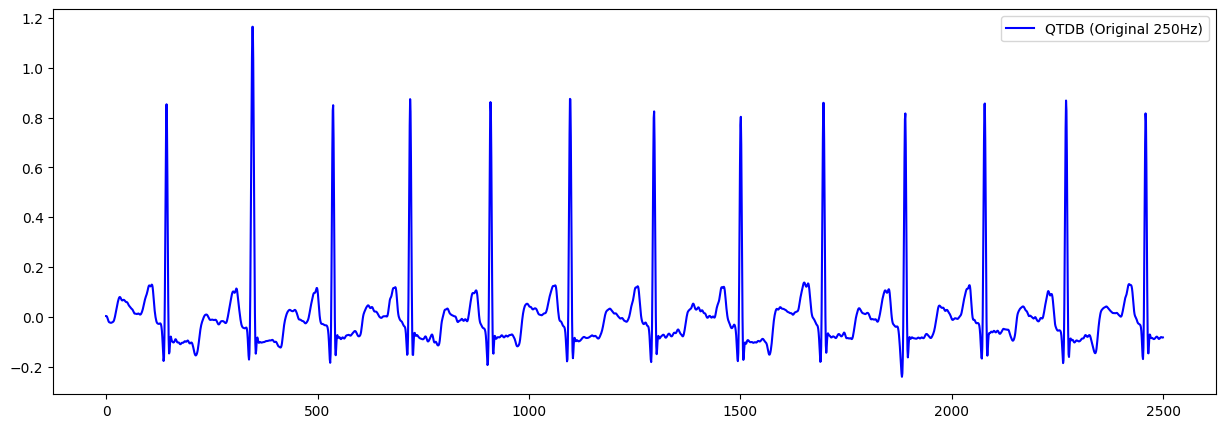

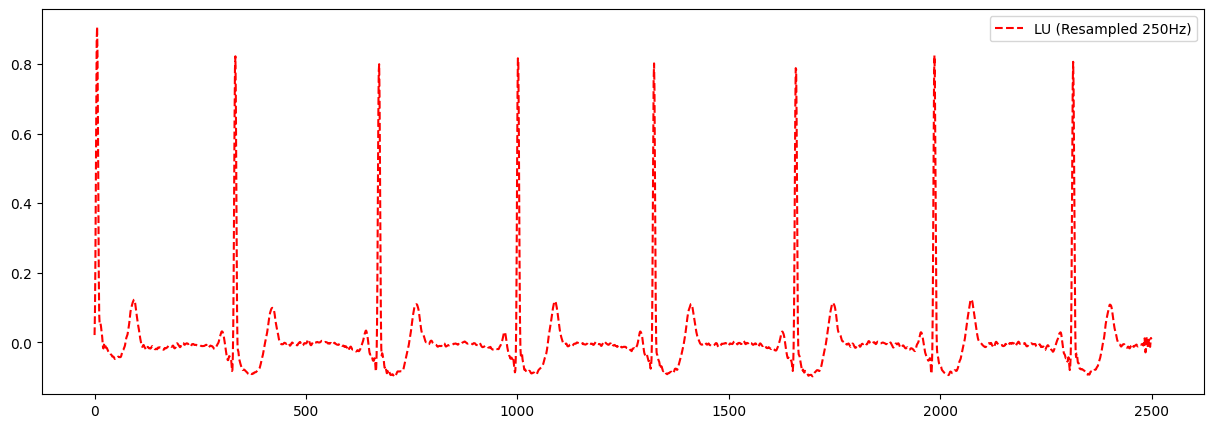

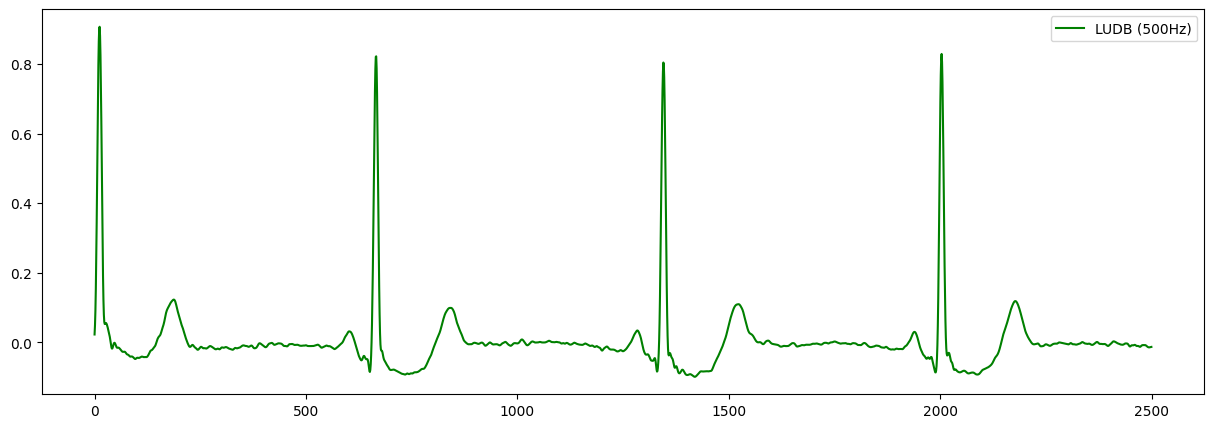

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
plt.plot(qt_signal[:2500], label=f"QTDB (Original {qt_fs}Hz)", color='blue')
plt.legend()
plt.show()
plt.figure(figsize=(15, 5))
plt.plot(lu_signal_resampled[:2500], label=f"LU (Resampled {lu_fs_resampled}Hz)", linestyle='dashed', color='red')
plt.legend()
plt.show()
plt.figure(figsize=(15, 5))
plt.plot(lu_signal[:2500], label=f"LUDB ({lu_fs}Hz)", color='green')
plt.legend()
plt.show()


In [ ]:
import numpy as np
def create_binary_mask(signal, qrs_regions):
    mask = np.zeros(len(signal))
    for start, end in qrs_regions:
        mask[start:end] = 1  # Mark QRS regions as 1
    return mask

# Create binary masks
qt_mask = create_binary_mask(qt_signal, qt_qrs_regions)
lu_mask = create_binary_mask(lu_signal_resampled, lu_qrs_regions_resampled)
print(lu_mask[lu_mask>0])

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
def segment_signal_and_mask(signal, mask, window_size, fs):
    segments = []
    masks = []
    for i in range(0, len(signal) - window_size, window_size // 2):  # 50% overlap
        segment = signal[i:i + window_size]
        mask_segment = mask[i:i + window_size]
        segments.append(segment)
        masks.append(mask_segment)
    return np.array(segments), np.array(masks)

# Segment the signals and masks
window_size = int(1 * lu_fs)  # 1-second window (based on LUDB's fs)
qt_segments, qt_masks = segment_signal_and_mask(qt_signal, qt_mask, window_size, qt_fs)
lu_segments, lu_masks = segment_signal_and_mask(lu_signal_resampled, lu_mask, window_size, lu_fs_resampled)
print(lu_segments)
print(lu_masks[lu_masks>0])


[[ 2.10114019e-02  9.17258443e-02  2.37680313e-01 ... -2.20004055e-03
  -2.61294451e-03 -3.06252170e-03]
 [-8.42689523e-03 -9.34366190e-03 -1.04186687e-02 ...  2.15241234e-02
   3.11032701e-02  4.09264687e-02]
 [-3.08826201e-03 -2.32205804e-03 -3.65117295e-04 ...  4.77240165e-02
   2.25428999e-01  4.67433040e-01]
 ...
 [-1.28664545e-02 -1.25456831e-02 -1.24449466e-02 ...  1.12233909e-01
   1.09823252e-01  1.07292479e-01]
 [-8.67566024e-03 -5.87784911e-03 -3.58003144e-03 ... -6.03430814e-02
  -6.22473960e-02 -6.52494089e-02]
 [ 1.04040800e-01  9.92065123e-02  9.26276381e-02 ... -2.13931927e-02
  -2.18035215e-02 -1.92115992e-02]]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

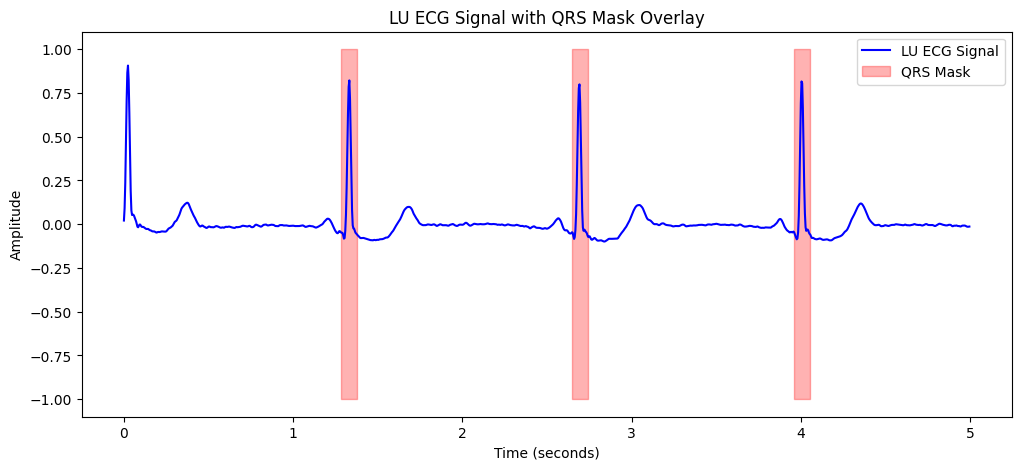

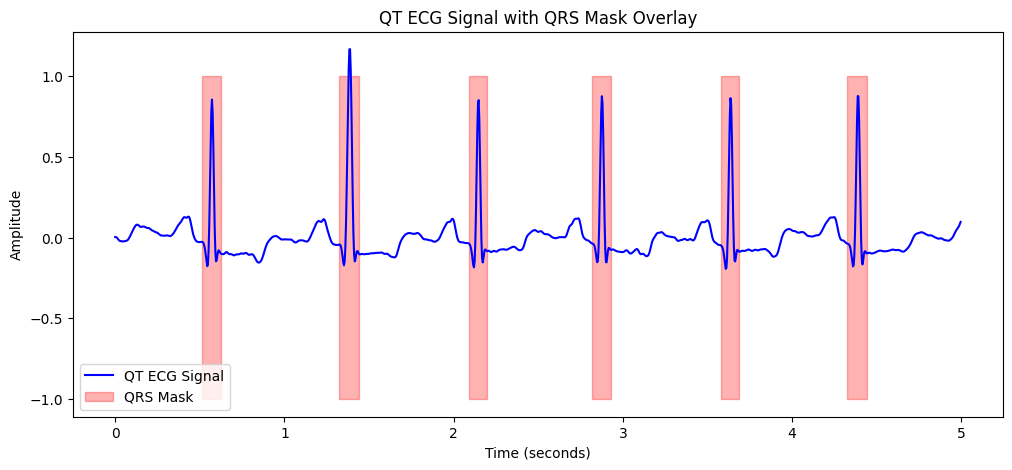

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define a time window for visualization (e.g., first 10 seconds)
start_index = 0 * lu_fs_resampled
end_index = 5 * lu_fs_resampled

samples_to_plot=end_index-start_index
# Create time axis
time = np.arange(samples_to_plot) / lu_fs_resampled

# Plot the ECG signal
plt.figure(figsize=(12, 5))
plt.plot(time, lu_signal_resampled[:samples_to_plot], label='LU ECG Signal', color='b')

# Overlay the QRS mask (shaded in red)
plt.fill_between(time, -1, 1, where=lu_mask[:samples_to_plot] > 0, color='r', alpha=0.3, label='QRS Mask')

# Labels and legend
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title('LU ECG Signal with QRS Mask Overlay')
plt.legend()
plt.show()

# Plot the ECG signal
plt.figure(figsize=(12, 5))
plt.plot(time, qt_signal[:samples_to_plot], label='QT ECG Signal', color='b')

# Overlay the QRS mask (shaded in red)
plt.fill_between(time, -1, 1, where=qt_mask[:samples_to_plot] > 0, color='r', alpha=0.3, label='QRS Mask')

# Labels and legend
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title('QT ECG Signal with QRS Mask Overlay')
plt.legend()
plt.show()



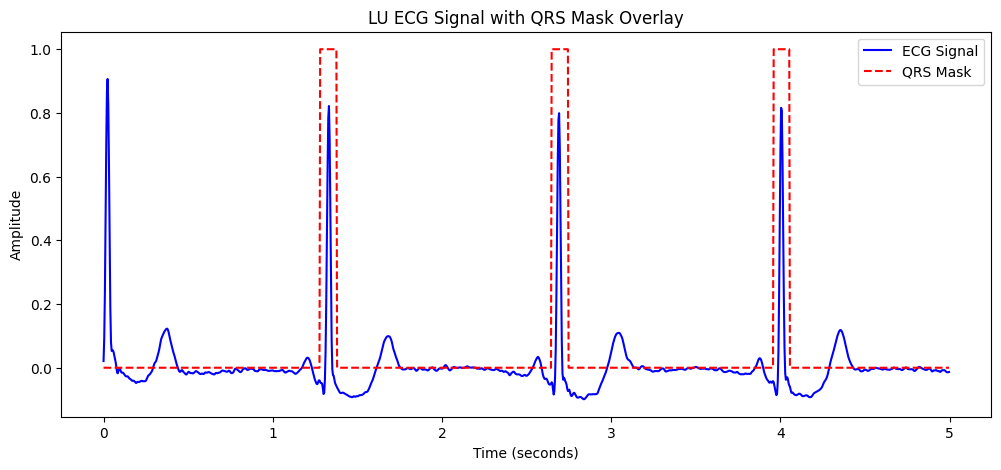

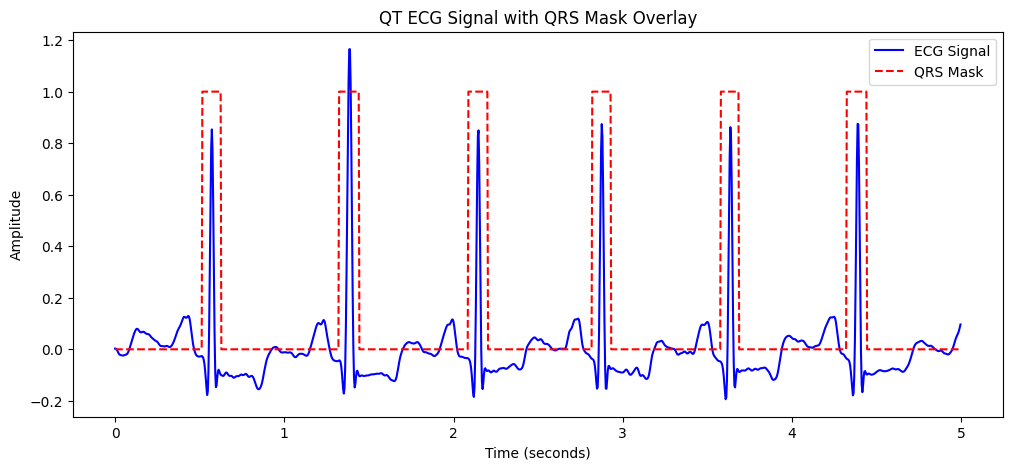

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

start_index = 0 * lu_fs_resampled
end_index = 5 * lu_fs_resampled

samples_to_plot=end_index-start_index
# Create time axis
time = np.arange(samples_to_plot) / lu_fs_resampled

# Plot the ECG signal
plt.figure(figsize=(12, 5))
plt.plot(time, lu_signal_resampled[start_index:end_index], label='ECG Signal', color='b')

# Plot the QRS mask as a separate line
plt.plot(time, lu_mask[start_index:end_index], label='QRS Mask', color='r', linestyle='dashed')

# Labels and legend
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title('LU ECG Signal with QRS Mask Overlay')
plt.legend()
plt.show()


# Plot the ECG signal
plt.figure(figsize=(12, 5))
plt.plot(time, qt_signal[start_index:end_index], label='ECG Signal', color='b')

# Plot the QRS mask as a separate line
plt.plot(time, qt_mask[start_index:end_index], label='QRS Mask', color='r', linestyle='dashed')

# Labels and legend
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title('QT ECG Signal with QRS Mask Overlay')
plt.legend()
plt.show()



In [ ]:
# Combine data from both datasets
X = np.concatenate([qt_segments, lu_segments])
y = np.concatenate([qt_masks, lu_masks])

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, ReLU, Add, Dense

def TCN(input_shape, num_filters, kernel_size, num_blocks, dropout_rate):
    inputs = Input(shape=input_shape)
    x = inputs
    for _ in range(num_blocks):
        # Residual block
        res = x
        x = Conv1D(num_filters, kernel_size, padding='causal')(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = Conv1D(num_filters, kernel_size, padding='causal')(x)
        x = BatchNormalization()(x)
        x = Add()([x, res])
        x = ReLU()(x)
    x = Conv1D(1, kernel_size=1, activation='sigmoid')(x)  # Output sequence of probabilities
    model = Model(inputs, x)
    return model

# Define the TCN model
input_shape = (window_size, 1)
model = TCN(input_shape, num_filters=64, kernel_size=3, num_blocks=4, dropout_rate=0.2)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 500, 1)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_9 (Conv1D)         │ (None, 500, 64)        │            256 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_8     │ (None, 500, 64)        │            256 │ conv1d_9[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_8 (ReLU)            │ (None, 500, 64)        │              0 │ batch_normalization_8… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_10 (Conv1D)        │ (None, 500, 64)        │         12,352 │ re_lu_8[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_9     │ (None, 500, 64)        │            256 │ conv1d_10[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_4 (Add)               │ (None, 500, 64)        │              0 │ batch_normalization_9… │
│                           │                        │                │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_9 (ReLU)            │ (None, 500, 64)        │              0 │ add_4[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_11 (Conv1D)        │ (None, 500, 64)        │         12,352 │ re_lu_9[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_10    │ (None, 500, 64)        │            256 │ conv1d_11[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_10 (ReLU)           │ (None, 500, 64)        │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_12 (Conv1D)        │ (None, 500, 64)        │         12,352 │ re_lu_10[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_11    │ (None, 500, 64)        │            256 │ conv1d_12[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_5 (Add)               │ (None, 500, 64)        │              0 │ batch_normalization_1… │
│                           │                        │                │ re_lu_9[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_11 (ReLU)           │ (None, 500, 64)        │              0 │ add_5[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_13 (Conv1D)        │ (None, 500, 64)        │         12,352 │ re_lu_11[0][0]         │
├──────────────────────

 Total params: 88,833 (347.00 KB)

 Trainable params: 87,809 (343.00 KB)

 Non-trainable params: 1,024 (4.00 KB)

In [ ]:
# Reshape data for TCN input
X_train = X_train.reshape(-1, window_size, 1)
X_val = X_val.reshape(-1, window_size, 1)
X_test = X_test.reshape(-1, window_size, 1)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)

Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 275ms/step - accuracy: 0.8229 - loss: 0.3746 - val_accuracy: 0.9288 - val_loss: 0.5373
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 250ms/step - accuracy: 0.9581 - loss: 0.1515 - val_accuracy: 0.9198 - val_loss: 0.4267
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 198ms/step - accuracy: 0.9571 - loss: 0.1390 - val_accuracy: 0.8928 - val_loss: 0.3750
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 239ms/step - accuracy: 0.9635 - loss: 0.1037 - val_accuracy: 0.8870 - val_loss: 0.3647
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 194ms/step - accuracy: 0.9681 - loss: 0.0885 - val_accuracy: 0.8870 - val_loss: 0.3792
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 206ms/step - accuracy: 0.9680 - loss: 0.0867 - val_accuracy: 0.8870 - val_loss: 0.3725
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 248ms/step - accuracy: 0.9691 - loss: 0.0863 - val_accuracy: 0.8870 - val_loss: 0.3826
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 201ms/step - accuracy: 0.9713 - loss: 0.0847 - val_accuracy: 

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.8937 - loss: 0.4150
Test Accuracy: 0.8954834938049316
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step


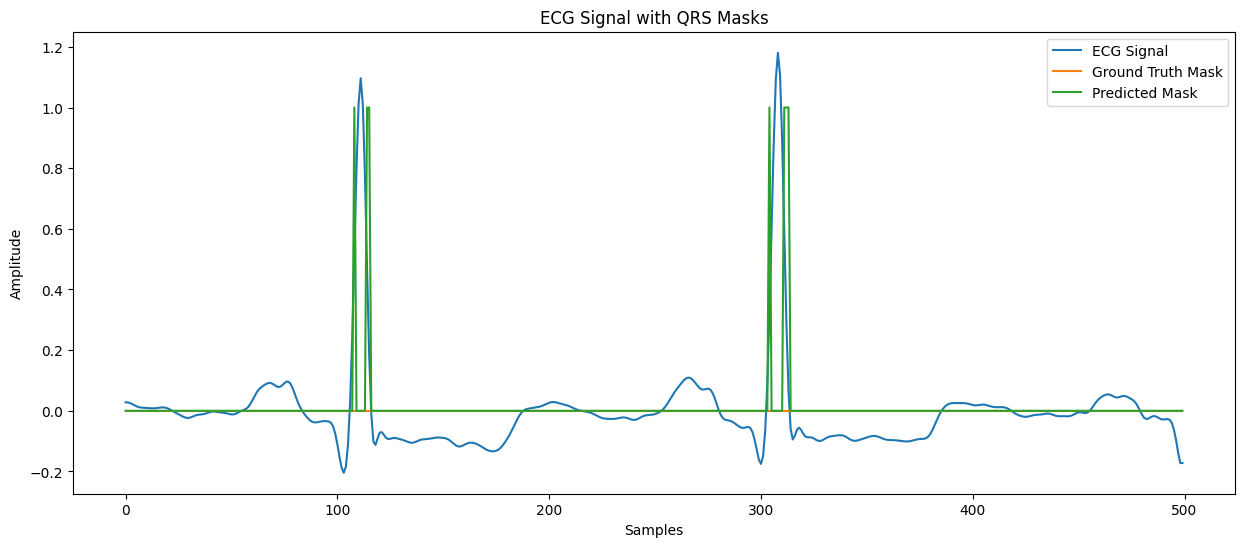

In [ ]:
# Evaluate on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc}")

# Predict on the test set
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary masks

# Visualize predictions
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.plot(X_test[0].flatten(), label='ECG Signal')
plt.plot(y_test[0].flatten(), label='Ground Truth Mask')
plt.plot(y_pred[0].flatten(), label='Predicted Mask')
plt.title('ECG Signal with QRS Masks')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

In [ ]:
import wfdb

# Load the new ECG signal
new_record = wfdb.rdrecord('/content/physionet.org/files/mitdb/1.0.0/100')

new_signal = new_record.p_signal[:, 0]  # Use lead I
new_fs = new_record.fs  # Sampling frequency

# Extract the first 10 seconds
first_10_seconds = new_signal[:int(10 * new_fs)]
print(first_10_seconds.shape)

(3600,)


In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

first_10_seconds = smooth_signal(bandpass_filter(first_10_seconds))

first_10_seconds = resample_signal(first_10_seconds, original_fs=new_fs, target_fs=250)
# Segment the signal into fixed-length windows
def segment_signal(signal, window_size, fs):
    segments = []
    for i in range(0, len(signal) - window_size, window_size // 2):  # 50% overlap
        segment = signal[i:i + window_size]
        segments.append(segment)
    return np.array(segments)

window_size = int(1 * new_fs)  # 1-second window
new_segments = segment_signal(first_10_seconds, window_size , new_fs)

# Reshape for TCN input
new_segments = new_segments.reshape(-1, window_size, 1)
print(new_segments.shape)

(12, 360, 1)


In [ ]:
# Predict QRS regions
y_pred = model.predict(new_segments)
print(y_pred)
y_pred = (y_pred > 0.1).astype(int)  # Convert probabilities to binary masks
print(y_pred[y_pred > 0])  # P
# Combine predictions into a single mask
full_mask = np.zeros(len(first_10_seconds))
for i, segment in enumerate(new_segments):
    start = i * (window_size // 2)
    end = start + window_size
    full_mask[start:end] = np.maximum(full_mask[start:end], y_pred[i].flatten())


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
[[[0.00178176]
  [0.00336577]
  [0.0050314 ]
  ...
  [0.00175186]
  [0.00159855]
  [0.00163166]]

 [[0.0021234 ]
  [0.00415363]
  [0.00347918]
  ...
  [0.0020476 ]
  [0.00210671]
  [0.00228362]]

 [[0.00156938]
  [0.00559364]
  [0.00383937]
  ...
  [0.005164  ]
  [0.00672462]
  [0.00467385]]

 ...

 [[0.00161779]
  [0.00596005]
  [0.00474273]
  ...
  [0.00133661]
  [0.00125224]
  [0.00130967]]

 [[0.00192666]
  [0.00407059]
  [0.00352273]
  ...
  [0.00102856]
  [0.00106947]
  [0.0018575 ]]

 [[0.00153795]
  [0.00558832]
  [0.00401875]
  ...
  [0.00501601]
  [0.00969129]
  [0.01102677]]]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [ ]:
def extract_qrs_from_mask(mask):
    qrs_regions = []
    start = None
    for i in range(len(mask)):
        if mask[i] == 1 and start is None:  # Start of QRS region
            start = i
        elif mask[i] == 0 and start is not None:  # End of QRS region
            end = i
            qrs_regions.append((start, end))
            start = None
    return qrs_regions

qrs_regions = extract_qrs_from_mask(full_mask)
print(qrs_regions)

[(51, 52), (55, 60), (248, 249), (253, 255), (259, 264), (452, 453), (457, 459), (462, 467), (655, 656), (658, 664), (847, 848), (852, 854), (857, 862), (1043, 1045), (1049, 1051), (1054, 1059), (1247, 1249), (1253, 1255), (1258, 1263), (1410, 1412), (1417, 1418), (1422, 1426), (1660, 1661), (1665, 1667), (1671, 1676), (1870, 1872), (1876, 1878), (1881, 1886), (2073, 2075), (2079, 2081), (2083, 2088), (2271, 2273), (2277, 2278), (2282, 2286)]


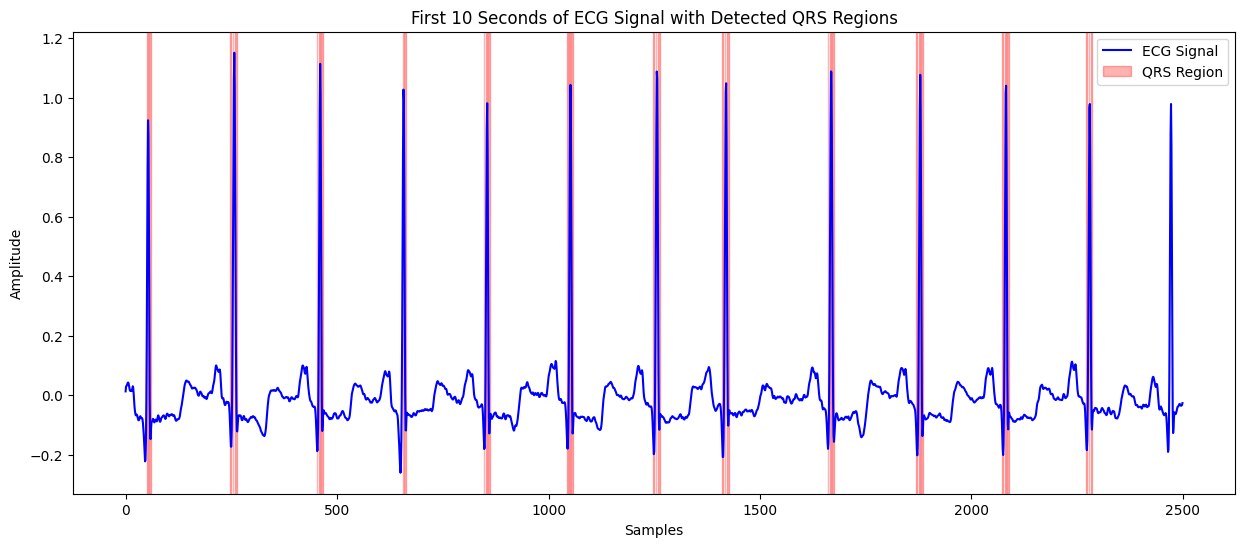

In [ ]:
import matplotlib.pyplot as plt

# Plot the first 10 seconds of the ECG signal
plt.figure(figsize=(15, 6))
plt.plot(first_10_seconds, label='ECG Signal', color='b')

# Highlight QRS regions
for start, end in qrs_regions:
    plt.axvspan(start, end, color='r', alpha=0.3, label='QRS Region' if start == qrs_regions[0][0] else "")

plt.title('First 10 Seconds of ECG Signal with Detected QRS Regions')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
#plt.plot(y_pred[0].flatten(), label='Predicted Mask')
plt.legend()
plt.show()

51 52
55 60
248 249
253 255
259 264
452 453
457 459
462 467
655 656
658 664
847 848
852 854
857 862
1043 1045
1049 1051
1054 1059
1247 1249


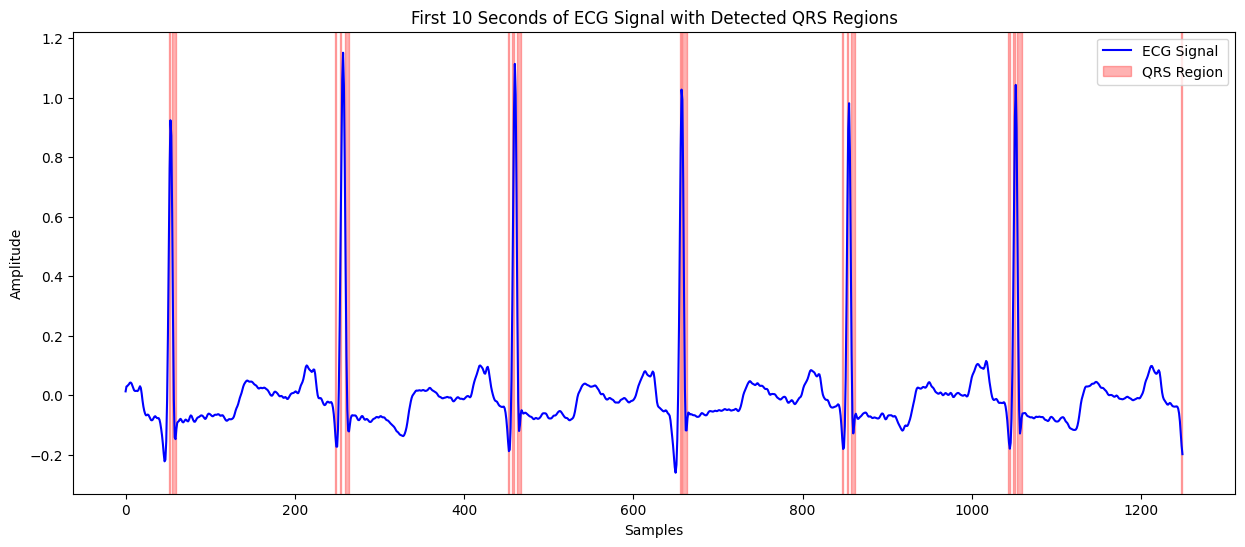

In [ ]:
import matplotlib.pyplot as plt

# Plot the first 10 seconds of the ECG signal
plt.figure(figsize=(15, 6))
plt.plot(first_10_seconds[:5*250], label='ECG Signal', color='b')

# Highlight QRS regions
for start, end in qrs_regions:
  if start < 5*250:
    plt.axvspan(start, end, color='r', alpha=0.3, label='QRS Region' if (start == qrs_regions[0][0] ) else "")
    print (start,end)

plt.title('First 10 Seconds of ECG Signal with Detected QRS Regions')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
#plt.plot(y_pred[0].flatten(), label='Predicted Mask')
plt.legend()
plt.show()